In [2]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [7]:

#using single family home prices historical dataset (zillow has a few other options as well to try including w/ condos, Xbedrooms, etc.)
sfh_prices = pd.read_csv("/Users/afrazier/Documents/personal/real_estate/data/zillow_sfh_values_historical_zipcode.csv")
print(sfh_prices.index.size)

30445


In [8]:
#pre-processing, filter out zipcodes without significant populations
twenty_ten_census_zip_populations = pd.read_csv("data/population_by_zip_2010.csv")
zip_populations = twenty_ten_census_zip_populations.groupby('zipcode')['population'].sum().reset_index()
prices_with_pops = sfh_prices.merge(zip_populations, left_on="RegionName", right_on="zipcode")
print(prices_with_pops.index.size)
#filter to zips with atleast 25K people living there
min_population = 25000
prices_with_pops = prices_with_pops[prices_with_pops.population>min_population]
print(prices_with_pops.index.size)
sfh_prices = prices_with_pops

29892
10344


In [142]:
#melt the date,price into multiple rows instead of one wide table
date_cols = [x for x in sfh_prices.columns if sfh_prices[x].dtype=='float64']
melted_prices = pd.melt(sfh_prices, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName','State', 'City', 'Metro', 'CountyName'], value_vars=date_cols)
melted_prices = melted_prices.rename(columns = {"variable": "date", "value": "price"})
melted_prices.date = pd.to_datetime(melted_prices.date)
# remove years/zips with null prices -> 693977/5044869 (~14%) null prices 
melted_prices = melted_prices[~(melted_prices.price.isnull())]
#calculate monthly changes in price
melted_prices['monthly_price_change'] = melted_prices.sort_values(["RegionName", "date"])['price'].diff()


In [143]:
#add in the year distnace from the last date so we can perform regression on the price
max_date = melted_prices.date.max()
melted_prices['months_difference'] = (melted_prices.date-max_date)/(np.timedelta64(1, 'M'))

#filter to only datapoints from the last 5 years (12*5=16)
#can try other values here as it might be nice to include the 2008 crash as well
melted_prices = melted_prices[melted_prices.months_difference>-60]



In [144]:
#calculate slope, std, and number datapoints
zipcode_slopes = melted_prices.sort_values(["RegionID", "RegionName", "date"]).groupby(["RegionID", "RegionName"]).apply(
            lambda x: linregress(x.months_difference, x['price'])[0]).round()
zipcode_slopes.name = "monthly_price_slope"
zipcode_price_change_stds = melted_prices.groupby(["RegionID", "RegionName"])['monthly_price_change'].std().round()
zipcode_price_change_stds.name = "monthly_price_change_std"
zipcode_datapoints = melted_prices.groupby(["RegionID", "RegionName"])['price'].size()
zipcode_datapoints.name = "total_data_points"


In [145]:
zipcode_current_avg_price = melted_prices.sort_values(["RegionID", "RegionName", "date"]).groupby(["RegionID", "RegionName"])["RegionID", 'RegionName', 'price'].tail(1).set_index(["RegionID", "RegionName"])
zipcode_current_avg_price.rename(columns = {"price": "last_avg_price"}, inplace=True)


<ipython-input-145-8a4d9baacfed>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  zipcode_current_avg_price = melted_prices.sort_values(["RegionID", "RegionName", "date"]).groupby(["RegionID", "RegionName"])["RegionID", 'RegionName', 'price'].tail(1).set_index(["RegionID", "RegionName"])


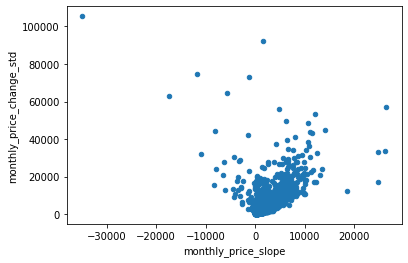

In [146]:
ten_year_slope_and_stds = pd.concat([zipcode_slopes, zipcode_price_change_stds, zipcode_datapoints, zipcode_current_avg_price], axis=1)
#lets filter to zipcodes with atleast 3 years of data?
ten_year_slope_and_stds =  ten_year_slope_and_stds[ten_year_slope_and_stds.total_data_points>=36]
ten_year_slope_and_stds.plot.scatter(x="monthly_price_slope", y="monthly_price_change_std")

In [147]:
ten_year_slope_and_stds['sharpe_ratios'] =  ten_year_slope_and_stds['monthly_price_slope']/ten_year_slope_and_stds['monthly_price_change_std']

#Lets Just look at zip codes with >2k a month
growth = ten_year_slope_and_stds[ten_year_slope_and_stds.monthly_price_slope>1000]
growth.sort_values('sharpe_ratios', ascending=False)[:25]

,,monthly_price_slope,monthly_price_change_std,total_data_points,last_avg_price,sharpe_ratios
RegionID,RegionName,,,,,
65791,19124,1146.0,505.0,61,156988.0,2.269307
99930,98632,2440.0,1167.0,61,356818.0,2.090831
82261,55411,1513.0,738.0,61,229052.0,2.050136
99926,98626,2541.0,1253.0,61,350000.0,2.027933
78294,46816,1100.0,568.0,61,156063.0,1.936620
71034,30314,3636.0,1884.0,61,288061.0,1.929936
65802,19135,1292.0,673.0,61,190724.0,1.919762
65805,19138,1465.0,765.0,61,191971.0,1.915033
76576,43207,1340.0,710.0,61,173794.0,1.887324


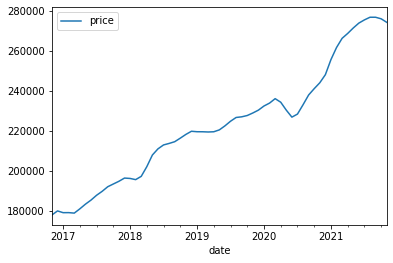

In [149]:
#interesting zipcodes 
# with slower appreciation but low std (risk)
#1. 84532 - Moab, UT (arches?!)
#2. 84032 - Wasatch County, Utah
#3. 98632 - Longview, WA 98632


#with larger appreciaion
#and still relatively low risk
#1. 91108 - Pasadena, CA  -> no houses in this specific zip?
#2. 90211 - Beverly Hills, CA 90211

melted_prices[melted_prices.RegionName==15201][['date', 'price']].set_index("date").plot()


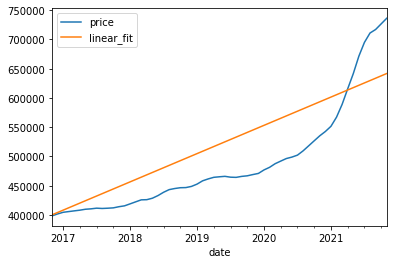

In [152]:
#why no austin, nash in these lists? which filter is removing them?
#east side has 4K appreciation with lowish std. -> 0.57 sharpe

# 78702, east side austin
ten_year_slope_and_stds[ten_year_slope_and_stds.index==78702]

fig, ax = plt.subplots()


price_plot = melted_prices[melted_prices.RegionName==78702][['date', 'price']].set_index("date").plot(ax=ax, label="actual")
linear_fit_x = price_plot.lines[0].get_xdata()
linear_fit_y = np.arange(400000,400000+4030.0*len(linear_fit_x), 4030)
# linear_fit_x = [x.to_timestamp() for x in linear_fit_x]
ax.plot(linear_fit_x, linear_fit_y, label="linear_fit")
plt.legend()
plt.show()

In [153]:

#austin has much higher appreciation in the last few years. can we build a slightly better forecast than linear?
#looking into some ETS and other slightly more advanced forecasting methods.
#what about zillows own forecasting data?

zillow_forcasts = pd.read_csv("data/zillow_sfh_forecasts.csv")

#lets grab the zip forecasts
zip_forcasts = zillow_forcasts[zillow_forcasts.Region=="Zip"]
zip_forcasts.RegionName = zip_forcasts.RegionName.astype("int64")


#merge these percentage changes with existing historical analysis
print(ten_year_slope_and_stds.index.size)
print(zip_forcasts.index.size)
historical_and_forecast = ten_year_slope_and_stds.reset_index().merge(zip_forcasts, left_on="RegionName", right_on="RegionName", how="left")
print(historical_and_forecast.index.size)
#losing around 1K zipcodes here?

10298
22574
10298


/usr/local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [154]:
historical_and_forecast['zillow_1yr_revenue_forecast'] = historical_and_forecast.last_avg_price*(historical_and_forecast.ForecastYoYPctChange*0.01)
historical_and_forecast.sort_values("ForecastYoYPctChange", ascending=False)[:25]

#lets filter to zips with >50K growth in the next year and sharpe ratio >1
stable_growth = historical_and_forecast[(historical_and_forecast.zillow_1yr_revenue_forecast>50000) & (historical_and_forecast.sharpe_ratios>1)]
stable_growth.sort_values("ForecastYoYPctChange", ascending=False)[:25]


# historical_and_forecast[historical_and_forecast.RegionName==78702]

,RegionID,RegionName,monthly_price_slope,monthly_price_change_std,total_data_points,last_avg_price,sharpe_ratios,Region,StateName,CountyName,CityName,ForecastedDate,ForecastYoYPctChange,zillow_1yr_revenue_forecast
3944,73230,34950,1231.0,1127.0,61,160609.0,1.092280,Zip,FL,Saint Lucie County,Fort Pierce,2022-11-30,31.3,50270.617
3480,72303,32922,1341.0,1330.0,61,177120.0,1.008271,Zip,FL,Brevard County,Cocoa,2022-11-30,29.1,51541.920
3704,72708,33605,2138.0,1792.0,61,242414.0,1.193080,Zip,FL,Hillsborough County,Tampa,2022-11-30,28.5,69087.990
3089,71034,30314,3636.0,1884.0,61,288061.0,1.929936,Zip,GA,Fulton County,Atlanta,2022-11-30,27.0,77776.470
3717,72722,33619,1778.0,1597.0,61,240791.0,1.113338,Zip,FL,Hillsborough County,Palm River-Clair Mel,2022-11-30,26.9,64772.779
3736,72774,33711,1833.0,1508.0,61,238296.0,1.215517,Zip,FL,Pinellas County,Saint Petersburg,2022-11-30,26.6,63386.736
3737,72775,33712,2241.0,2165.0,61,282378.0,1.035104,Zip,FL,Pinellas County,Saint Petersburg,2022-11-30,26.4,74547.792
3708,72713,33610,1819.0,1631.0,61,240473.0,1.115267,Zip,FL,Hillsborough County,Tampa,2022-11-30,26.3,63244.399
3706,72710,33607,2365.0,2305.0,61,338251.0,1.026030,Zip,FL,Hillsborough County,Tampa,2022-11-30,25.0,84562.750
3086,71031,30311,2901.0,1961.0,61,303406.0,1.479347,Zip,GA,Fulton County,Atlanta,2022-11-30,24.9,75548.094


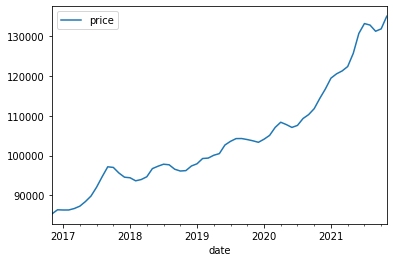

In [155]:
#interesting, zillow predicts fulton county atlanta to have highest increase in the next year?
melted_prices[melted_prices.RegionName==15208][['date', 'price']].set_index("date").plot()


In [156]:
#requirements -> good sharpe ratio of risk to return. ideally >1

# forecasted annual property value increase of >20K (and >10%)
#have a basic linear model but might want to look into other things here


#things to add
# population is growing at decent rate
# major school, grocery store, and hospital within 10-20 miles of home
# Average salary/income shows a positive trend for this place too! 


# rental yield is strong. ie, i can make 1% of house cost in rent each year? (check vs BRRRRR book rule)
# or I can make X dollars in rent each year. 

In [157]:
#only have 2093 zipcodes with rent; need additional sources
rental_yields = pd.read_csv("data/zillow_Rent_estimtaes.csv")


In [158]:
# rental_yields.MsaName.drop_duplicates().size
# historical_and_forecast.CityName.drop_duplicates().size#.RegionName.drop_duplicates().size


def cleanup_zips(df):
    df.RegionName = df.RegionName.astype("string")
    #filter out the few zips with only 3 digits
    df = df.loc[df.RegionName.str.len()>=4] 
    #add in a leading 0 for zips with only 4 digits
    df.loc[df.RegionName.str.len()==4, 'RegionName'] = ('0' + df[df.RegionName.str.len()==4].RegionName.astype("str"))
    #better logic for matching zips on the first 3 numbers (adding in 0 for zips with only 4 digits)
    #then finding the zip with min abs value between remaining digits
    df['first_three_zip_digits'] = df.RegionName.str[0:3]
    df['last_two_zip_digits'] = df.RegionName.str[3:5].astype("int64")
    return df




historical_and_forecast = cleanup_zips(historical_and_forecast)


/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-158-d9591a0ee767>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_three_zip_digits'] = df.RegionName.str[0:3]
<ipython-input-158-d9591a0ee767>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [159]:
#eventually we can add in the rate of rent increases to project rental yields in the future.
#for now lets just see how much zipcodes are renting at as of last month of data (then compare to housing costs)
last_month_rental_yields = rental_yields[['RegionID', 'RegionName', rental_yields.columns[-1]]]
last_month_rental_yields.rename(columns = {rental_yields.columns[-1]: "monthly_rent_approx"}, inplace=True)

last_month_rental_yields = cleanup_zips(last_month_rental_yields)


/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/usr/local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [172]:
#lets try and join with the closest zip code (should be same zipcode if present)

rent_and_forecasts = historical_and_forecast.merge(last_month_rental_yields, how="inner", on="first_three_zip_digits")
rent_and_forecasts['zip_abs_diff'] = abs(rent_and_forecasts.last_two_zip_digits_x-rent_and_forecasts.last_two_zip_digits_y)
closest_zips = rent_and_forecasts.groupby(['RegionName_x'])['zip_abs_diff'].idxmin()


In [207]:
# rent_and_forecasts[rent_and_forecasts.RegionName_x=="15201"]
closest_zip_data[closest_zip_data.RegionName_x=="15201"]

,RegionID_x,RegionName_x,monthly_price_slope,monthly_price_change_std,total_data_points,last_avg_price,sharpe_ratios,Region,StateName,CountyName,...,ForecastedDate,ForecastYoYPctChange,zillow_1yr_revenue_forecast,first_three_zip_digits,last_two_zip_digits_x,RegionID_y,RegionName_y,monthly_rent_approx,last_two_zip_digits_y,zip_abs_diff
5786,63932,15201,1611.0,2066.0,61,274407.0,0.779768,Zip,PA,Allegheny County,...,2022-11-30,15.9,43630.713,152,1,63934,15203,1487.0,3,2


In [173]:
closest_zip_data = rent_and_forecasts.loc[closest_zips]
assert(closest_zip_data.loc[closest_zip_data.RegionName_x=='10016', 'RegionName_y'].values[0]=='10016')


In [208]:
#okay now we have rental data for much more zips but some of the zips rentals may be a bit of a stretch (might need to throw some out with zip_abs_diff > X)
# 6043 of the initial 10294 zips have a matching 3 letter start of their zipcode
print(historical_and_forecast.index.size)
print(closest_zip_data.index.size)
closest_zip_data[['RegionName_x', 'RegionName_y', 'zip_abs_diff']].sort_values("zip_abs_diff", ascending=False)


10295
6016


,RegionName_x,RegionName_y,zip_abs_diff
29177,40299,40204,95
10067,21797,21704,93
10063,21795,21704,91
10059,21793,21704,89
29176,40291,40204,87
...,...,...,...
28447,37027,37027,0
10405,22209,22209,0
10396,22207,22207,0
28493,37064,37064,0


In [209]:

# print(historical_and_forecast.index.size)
# apprecation_and_rent = historical_and_forecast.merge(last_month_rental_yields, on="RegionID", how="left")
# print(apprecation_and_rent.index.size)
# we only have rental yields for ~1/5 of the zipcodes?
# maybe we should use the city ones instead? to get more data values, and then apply zipcodes when we can?

#try merging primary on zip and then use city as backup for places we cant get a zip. 

In [211]:
(closest_zip_data.RegionName_x=="15201").sum()

1

In [212]:
# rental data includes multifamily but prices/apprecaiton data is only SFHs so 
# this calculation of rental yield might be a bit off but atleast it should be skewed for all zipcodes
# and therfore still work as a way to sort them by renatl yields

#overall rental yields may be less though. try and check a few locations to see if the values are close and if we can 
#do any transformations to help



closest_zip_data['approx_rental_yield'] = closest_zip_data.monthly_rent_approx/closest_zip_data.last_avg_price
closest_zip_data.sort_values("approx_rental_yield", ascending=False)[:25]

,RegionID_x,RegionName_x,monthly_price_slope,monthly_price_change_std,total_data_points,last_avg_price,sharpe_ratios,Region,StateName,CountyName,...,ForecastYoYPctChange,zillow_1yr_revenue_forecast,first_three_zip_digits,last_two_zip_digits_x,RegionID_y,RegionName_y,monthly_rent_approx,last_two_zip_digits_y,zip_abs_diff,approx_rental_yield
5701,62297,11950,2639.0,2130.0,61,377097.0,1.238967,Zip,NY,Suffolk County,...,12.5,47137.125,119,50,62287,11937,28297.0,37,13,0.075039
5693,62280,11901,2498.0,2498.0,61,508556.0,1.000000,Zip,NY,Suffolk County,...,10.8,54924.048,119,1,62287,11937,28297.0,37,36,0.055642
5699,62296,11949,2541.0,3281.0,61,626965.0,0.774459,Zip,NY,Suffolk County,...,10.3,64577.395,119,49,62287,11937,28297.0,37,12,0.045133
28375,73377,35207,300.0,618.0,61,45921.0,0.485437,Zip,AL,Jefferson County,...,17.9,8219.859,352,7,73375,35205,1807.0,5,2,0.039350
5697,62293,11946,3687.0,4515.0,61,759934.0,0.816611,Zip,NY,Suffolk County,...,11.5,87392.410,119,46,62287,11937,28297.0,37,9,0.037236
11303,69394,27536,215.0,285.0,61,56495.0,0.754386,Zip,NC,Vance County,...,8.0,4519.600,275,36,69397,27540,1927.0,40,4,0.034109
28366,73374,35204,417.0,615.0,61,55704.0,0.678049,Zip,AL,Jefferson County,...,21.0,11697.840,352,4,73375,35205,1807.0,5,1,0.032439
5993,65694,19013,212.0,617.0,61,61406.0,0.343598,Zip,PA,Delaware County,...,15.1,9272.306,190,13,65738,19063,1898.0,63,50,0.030909
28387,73381,35211,303.0,692.0,61,60576.0,0.437861,Zip,AL,Jefferson County,...,18.4,11145.984,352,11,73375,35205,1807.0,5,6,0.029830
36106,85931,63113,-46.0,1284.0,61,47668.0,-0.035826,Zip,MO,Saint Louis City,...,19.5,9295.260,631,13,85930,63112,1345.0,12,1,0.028216


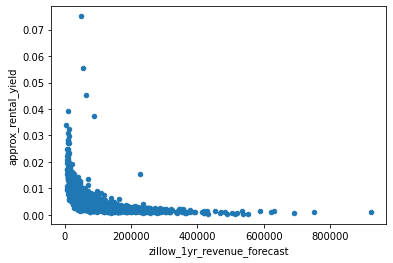

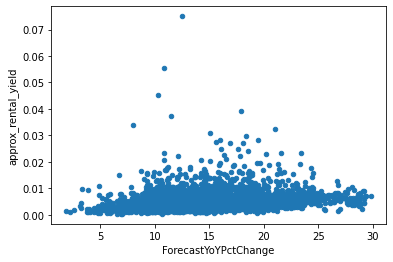

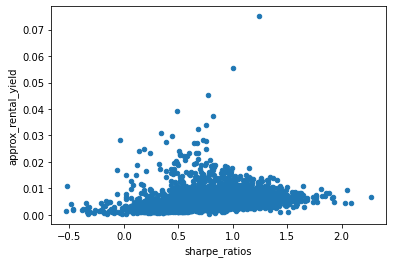

In [213]:
#rental yield on y axis and 1 year appreciation forecast on the x
#trade off for appreciation vs rent.

closest_zip_data.plot.scatter(x="zillow_1yr_revenue_forecast", y="approx_rental_yield")

closest_zip_data.plot.scatter(x="ForecastYoYPctChange", y="approx_rental_yield")

closest_zip_data.plot.scatter(x="sharpe_ratios", y="approx_rental_yield")

In [218]:
alexs_shortlist = closest_zip_data[(closest_zip_data.approx_rental_yield>0.008) & (closest_zip_data.sharpe_ratios>0.5) & (closest_zip_data.last_avg_price<=500000) & (closest_zip_data.last_avg_price>130000) & (closest_zip_data.ForecastYoYPctChange>10)].sort_values("ForecastYoYPctChange", ascending=False)
alexs_shortlist.to_csv("alexs_shortlist_updated_12_21_2021.csv", index=False)

In [219]:
#interesting places to look to buy:

# currently going down the list and checking out each zip on wikepedia and google maps
# on 90201


#FL
    #1. Melbourne, FL 32935
    #2. 33523 (Dade) ? 
    #3. 33415, 33417 (palm beach)


#TX
    #zips near fortworth, tx (dallas)
    #1. 76110, 
    #1. 76086, 76085, 76088, 76087, 76082 weatherford tx
    #2. 


#NC
    #1. 28168 ??
    #2. 28147 (charlotte/salisbury)
    

#TN

    #1. 37040, 37042 (clarksville) 5th largest city in TN


#CA

    #1. 92311 (barstow)
    #2. 92274, 92254 (near joshua tree?)
    #3. 90201   (bell gardens, LA)
    

#NY

    #1. 11951, 11950, 11967  (shirley, mastic, mastic beach)
    #2. Middle Island, NY 11953
    #3. haven 11961
    #4. peekskill nyc 10566, Mt Vernon, NY 10550, 10562 (westchester county)
    #5. Putnam County 10579, 10512, 10541, 10509


#IL

    #1. 60609 (back of yads, chicago)
    #2. Calumet Park, IL 60643

In [220]:

alexs_shortlist = pd.read_csv("alexs_shortlist_updated_12_21_2021.csv")

In [221]:
alexs_shortlist[alexs_shortlist.StateName=="PA"]#

,RegionID_x,RegionName_x,monthly_price_slope,monthly_price_change_std,total_data_points,last_avg_price,sharpe_ratios,Region,StateName,CountyName,...,ForecastYoYPctChange,zillow_1yr_revenue_forecast,first_three_zip_digits,last_two_zip_digits_x,RegionID_y,RegionName_y,monthly_rent_approx,last_two_zip_digits_y,zip_abs_diff,approx_rental_yield
54,63939,15208,706.0,1256.0,61,134935.0,0.562102,Zip,PA,Allegheny County,...,19.5,26312.325,152,8,63942,15211,1385.0,11,3,0.010264
86,65806,19139,1512.0,1105.0,61,144265.0,1.368326,Zip,PA,Philadelphia County,...,17.8,25679.170,191,39,65806,19139,1257.0,39,0,0.008713
91,65334,18058,1445.0,2011.0,61,255124.0,0.718548,Zip,PA,Monroe County,...,17.5,44646.700,180,58,65337,18062,2110.0,62,4,0.008270
106,65367,18102,1079.0,753.0,61,144608.0,1.432935,Zip,PA,Lehigh County,...,16.9,24438.752,181,2,65368,18103,1599.0,3,1,0.011057
115,65750,19079,1094.0,1149.0,61,163953.0,0.952132,Zip,PA,Delaware County,...,16.3,26724.339,190,79,65757,19087,1995.0,87,8,0.012168
116,63952,15221,837.0,1053.0,61,139953.0,0.794872,Zip,PA,Allegheny County,...,16.3,22812.339,152,21,63948,15217,1482.0,17,4,0.010589
118,63945,15214,1187.0,1144.0,61,177100.0,1.037587,Zip,PA,Allegheny County,...,16.2,28690.200,152,14,63948,15217,1482.0,17,3,0.008368
139,65753,19082,1044.0,786.0,61,152998.0,1.328244,Zip,PA,Delaware County,...,15.7,24020.686,190,82,65757,19087,1995.0,87,5,0.013039
141,65372,18109,1055.0,1020.0,61,190856.0,1.034314,Zip,PA,Lehigh County,...,15.7,29964.392,181,9,65369,18104,2248.0,4,5,0.011779
150,63966,15235,857.0,1131.0,61,154324.0,0.757737,Zip,PA,Allegheny County,...,15.5,23920.220,152,35,63948,15217,1482.0,17,18,0.009603


In [139]:
closest_zip_data[(closest_zip_data.RegionID_x==15201)]

,RegionID_x,RegionName_x,monthly_price_slope,monthly_price_change_std,total_data_points,last_avg_price,sharpe_ratios,Region,StateName,CountyName,...,ForecastYoYPctChange,zillow_1yr_revenue_forecast,first_three_zip_digits,last_two_zip_digits_x,RegionID_y,RegionName_y,monthly_rent_approx,last_two_zip_digits_y,zip_abs_diff,approx_rental_yield


In [ ]:
#need some sort of data measurement of rent demand per zip. (ideally i dont want the house to be sitting or need to lower to get a tenat)